<a href="https://colab.research.google.com/github/darisoy/EE596_Project/blob/main/testing_CNNAutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🐍 Python setup

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets
import torchvision.transforms as T
from PIL import Image
import cv2
import numpy as np
import glob
import random
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 📀 Get the data

In [ ]:
!git clone https://github.com/darisoy/EE596_Project.git

# 😷 Get random mask

In [ ]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True, min_size=1000).to(device)

In [ ]:
def mask_out(img, output, thres=0.7):
    for idx, box in enumerate(output[0]['boxes'].tolist()):
        score = output[0]['scores'][idx].tolist()
        if score > thres: 
            mask = output[0]['masks'][idx][0].detach().cpu().numpy()
            mask[mask > 0.2] = 1
            mask = cv2.resize(mask, dsize=(img.shape[1], img.shape[0]))
            visMask = (255-(mask * 255)).astype("uint8")
            img = cv2.bitwise_and(img, img, mask=visMask)
    return img

In [ ]:
trf = T.Compose([T.ToTensor()])
def random_mask(i):
    maskname = '/content/EE596_Project/data/furnished/'+str(random.randint(0, 1227))+'.jpg'
    imagename = '/content/EE596_Project/data/empty/'+str(i)+'.jpg'
    model.eval()
    image = Image.open(glob.glob(maskname)[0])
    input = trf(image)
    input = torch.unsqueeze(input, 0).to(device)
    output = model(input)
    return cv2.imread(imagename), mask_out(cv2.imread(imagename), output)

In [ ]:
masked_images = []
for i in random.sample(range(0, 1000), 1):
    orig, masked = random_mask(i)
    cv2_imshow(orig)
    cv2_imshow(masked)

# 🎨 Fill in the gaps

In [45]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 4, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 16, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 2, stride=2),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
EPOCHS = 10
LEARNING_RATE = 0.001
MOMENTUM = 0.5
criterion = nn.MSELoss()
filler = ConvAutoEncoder()
optimizer = optim.SGD(filler.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

In [ ]:
for epoch in range(EPOCHS):
    filler.train()
    total_loss = 0.0
    for i in random.sample(range(0, 1328), 100):
        orig, masked = random_mask(i)
        optimizer.zero_grad()
        masked = torch.tensor(np.transpose(masked)).to(device) / 255.0
        pred = filler(masked.unsqueeze(dim=0))
        orig = cv2.resize(orig, dsize=(pred.shape[2], pred.shape[3]))
        orig = torch.tensor(np.transpose(orig)).to(device) / 255.0
        loss = criterion(pred, orig.unsqueeze(dim=0)) 
        loss.backward()
        total_loss += loss.item()
        optimizer.step()
    print('Train Epoch: %d \tLoss: %.6f' % (epoch, total_loss))

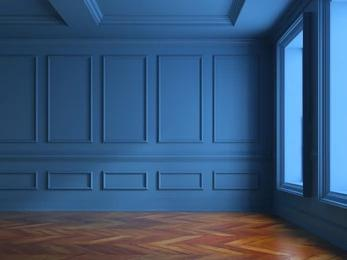

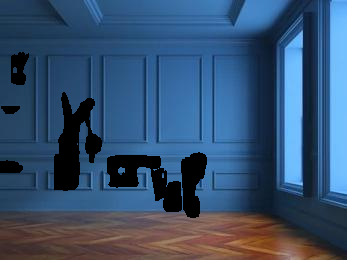

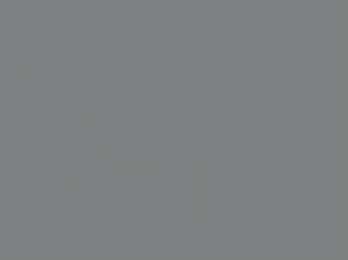

array([[[129.30896 , 128.78644 , 124.754524],
        [128.05452 , 128.69432 , 128.20624 ],
        [128.49261 , 129.24994 , 124.541626],
        ...,
        [127.92547 , 128.73056 , 128.08179 ],
        [128.35536 , 129.54456 , 124.36239 ],
        [127.9062  , 127.6566  , 128.25314 ]],

       [[125.014145, 130.2412  , 126.864426],
        [133.45424 , 129.03178 , 125.51215 ],
        [125.48352 , 130.53413 , 125.29607 ],
        ...,
        [133.24982 , 128.98032 , 125.62062 ],
        [125.67665 , 130.8357  , 124.75954 ],
        [134.70787 , 129.82172 , 126.01111 ]],

       [[128.81955 , 128.5206  , 125.20267 ],
        [128.06879 , 128.67961 , 127.84026 ],
        [129.02028 , 129.23973 , 125.18623 ],
        ...,
        [127.95762 , 128.75467 , 127.58723 ],
        [129.21944 , 129.43143 , 124.99911 ],
        [127.8306  , 128.23259 , 128.56938 ]],

       ...,

       [[125.298805, 129.74977 , 126.30146 ],
        [133.68466 , 129.07205 , 125.468994],
        [125.24638 , 1

In [50]:
filler.eval()
orig, masked = random_mask(974)
cv2_imshow(orig)
cv2_imshow(masked)
masked = torch.tensor(np.transpose(masked)).to(device) / 255.0
pred = filler(masked.unsqueeze(dim=0))
pred = np.transpose(pred.squeeze(dim=0).detach().numpy() * 255.0)
cv2_imshow(pred)
pred